In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyc-taxi-trip-duration/train.zip
/kaggle/input/nyc-taxi-trip-duration/test.zip
/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip


In [35]:
# import libraries: 

# To display plots directly in the notebook:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl 
import sklearn
import seaborn as sns
import zipfile
from sklearn.cluster import KMeans
import folium
from folium import plugins
from folium.plugins import HeatMap



In [36]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

In [37]:
zf_train = zipfile.ZipFile('../input/nyc-taxi-trip-duration/train.zip')
nyc_train_data = pd.read_csv(zf_train.open('train.csv'))

zf_test = zipfile.ZipFile('../input/nyc-taxi-trip-duration/test.zip')
nyc_test_data = pd.read_csv(zf_test.open('test.csv'))

In [38]:
nyc_train_data.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [39]:
train_length = len(nyc_train_data)
train_length


1458644

In [40]:
nyc_train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [41]:
nyc_train_data.describe()


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [42]:
#as the datatype of the datetimes is Object, we convert it into datetime-datatype: 

nyc_train_data['pickup_datetime'] = pd.to_datetime(nyc_train_data['pickup_datetime'])
nyc_train_data['dropoff_datetime'] = pd.to_datetime(nyc_train_data['dropoff_datetime'])
nyc_train_data['pickup_hour'] = nyc_train_data['pickup_datetime'].dt.hour
nyc_train_data['dropoff_hour'] = nyc_train_data['dropoff_datetime'].dt.hour



<AxesSubplot:xlabel='pickup_hour', ylabel='count'>

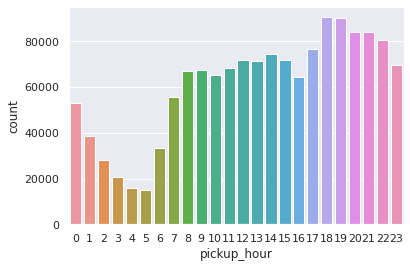

In [43]:
# after that create some plots/tables that display durations in correlation with different date and time types:

#copy data for charts:
nyc_2 = nyc_train_data.copy(deep=True)


# display amount of trips correlated to the daytime:
nyc_2['pickup_hour'] = nyc_2['pickup_datetime'].dt.hour


sns.set_theme(style='darkgrid', palette = 'Set2')
sns.countplot(x = nyc_2['pickup_hour'])

<AxesSubplot:xlabel='weekdays', ylabel='count'>

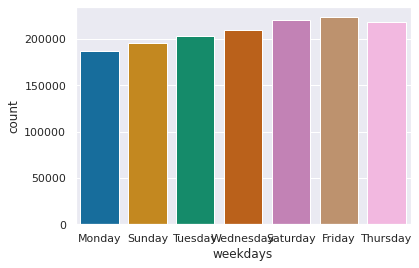

In [44]:
# display amount of trips correlated to the weekdays:

nyc_2['weekdays'] = nyc_2['pickup_datetime'].dt.strftime('%A')

sns.set_theme(style='darkgrid', palette = 'colorblind')
sns.countplot(x = nyc_2['weekdays'])
# komische Ordnung 



In [45]:
# ! not necessary 


# see relationship between vendor_id and trip_duration: 
# vendor_id is either 1 or 2

#x = nyc_train_data['vendor_id']
#y = nyc_train_data['trip_duration']
#plt.scatter(x, y, s=1, c='red')

#plt.yticks(np.arange(3.5,10.5, 0.5))
#plt.plot(x,y,'ro')
#plt.axis([0,5,0,20])
#plt.show()


#sns.set_theme(style='darkgrid', palette = 'colorblind')
#sns.countplot(x = x, y = y)

#sns.set(style = 'whitegrid')
# sns.violinplot(x = x, y = y,data = nyc_train_data)



In [46]:
# find correlations and relationships between the features: 

corr_matrix = nyc_train_data.corr().abs()
corr_matrix.style.background_gradient(cmap='coolwarm')

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_hour,dropoff_hour
vendor_id,1.000000,0.287415,0.007820,0.001742,0.001528,0.004496,0.020304,0.009299,0.009250
passenger_count,0.287415,1.000000,0.002169,0.005125,0.000343,0.002762,0.008471,0.009101,0.008449
pickup_longitude,0.007820,0.002169,1.000000,0.022568,0.783582,0.100190,0.026542,0.010150,0.010758
pickup_latitude,0.001742,0.005125,0.022568,1.000000,0.114884,0.494038,0.029204,0.010603,0.017043
dropoff_longitude,0.001528,0.000343,0.783582,0.114884,1.000000,0.124873,0.014678,0.022455,0.023361
dropoff_latitude,0.004496,0.002762,0.100190,0.494038,0.124873,1.000000,0.020677,0.013612,0.017246
trip_duration,0.020304,0.008471,0.026542,0.029204,0.014678,0.020677,1.000000,0.003690,0.002652
pickup_hour,0.009299,0.009101,0.010150,0.010603,0.022455,0.013612,0.003690,1.000000,0.933977
dropoff_hour,0.009250,0.008449,0.010758,0.017043,0.023361,0.017246,0.002652,0.933977,1.000000


possible correlations to have a look on: 
* vendor_id and passenger_count --> corr = 0.28
* pickup_longitude and dropoff_longitude --> corr = 0.78 
* pickup_latitude and dropoff_latitude --> corr = 0.49 
* pickup_hour and dropoff_hour --> corr = 0.94 




In [47]:
# cluster longitude/latitude of dropoff and pickup in clusters of new york areas: 


# create a dataframe only containing longitude and latitude since kmeans is an unsupervised task for unlabeled data: 
#nyc_coordinates = nyc_train_data[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].copy()
#coordinates_frame = pd.DataFrame(nyc_coordinates)
#pickup = nyc_2.loc[:,['id','pickup_latitude','pickup_longitude']]
#dropoff = nyc_2.loc[:,['id','dropoff_latitude','dropoff_longitude']]
#coordinates = [pickup,dropoff]


#kmeans = KMeans(n_clusters = 20, init ='k-means++')
#kmeans.fit(coordinates[coordinates.columns[1:3]]) # Compute k-means clustering.
#coordinates['cluster_label'] = kmeans.fit_predict(coordinates[coordinated.columns[1:3]])
#centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
#labels = kmeans.predict(coordinated[coordinates.columns[1:3]]) # Labels of each point
#pickup.head(10)

#X.plot.scatter(x = 'pickup_latitude', y = 'pickup_longitude', c=labels, s=50, cmap='viridis')
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

#new_df = old_df[['col1','col2']].copy()

#kmeans = KMeans(n_clusters=20)
#kmeans.fit(nyc_coordinates)
#y_kmeans = kmeans.predict(nyc_coordinates)

#plt.scatter(nyc_train_data['trip_duration'],y_kmeans, s=50, cmap='viridis')

#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

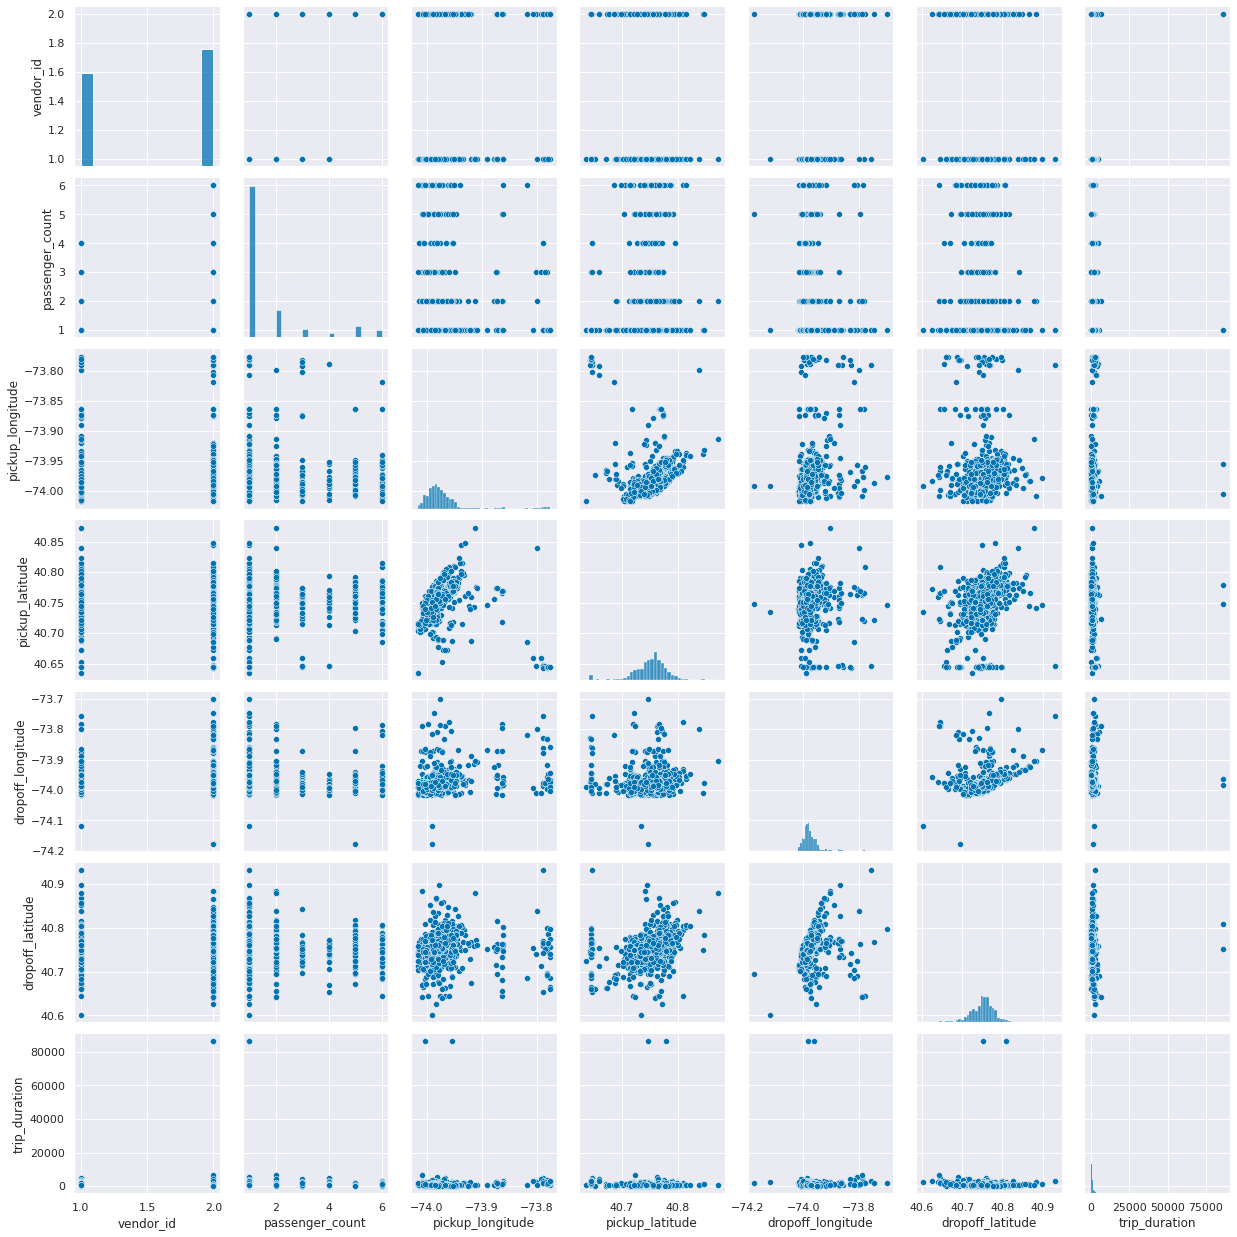

In [48]:
#display relationships bewtween all numeric features: 


sns.pairplot(nyc_train_data.sample(1000), vars=['vendor_id','passenger_count','pickup_longitude', 'pickup_latitude','dropoff_longitude','dropoff_latitude','trip_duration'], palette = "Set1") 
plt.show()

In [49]:
# chosen performance measure for regression task: RMSLE 

In [50]:
#adding heatmap to show neighborhoods/areas of new york with highly frequent taxi use with folium: 

pickUp_coordinates = nyc_train_data[['pickup_latitude','pickup_longitude']]
dropOff_coordinates = nyc_train_data[['dropoff_latitude' , 'dropoff_longitude']]

coordinates_test1 = pickUp_coordinates.sample(200)
coordinates_test2 = dropOff_coordinates.sample(200)



newYork  = folium.Map(location=[40.730610,-73.935242], zoom_start = 11)

HeatMap(coordinates_test1).add_to(newYork)
HeatMap(coordinates_test2).add_to(newYork)

newYork


In [53]:
# compute trip distance out of pick-up and dropoff: 
# using haversine: 

import haversine as hs 
from geopy.distance import great_circle 
from sklearn.metrics.pairwise import haversine_distances
from math import radians


# connect longitude and latitude data to coordinates for using haversine: 

#nyc_train_data['pickup_coordinates'] = list(zip(nyc_train_data.pickup_latitude,nyc_train_data.pickup_longitude))
#nyc_train_data['dropoff_coordinates'] = list(zip(nyc_train_data.dropoff_latitude, nyc_train_data.dropoff_longitude))

#nyc_train_data.head()
#sol = hs.haversine(nyc_train_data['pickup_coordinates'],nyc_train_data['dropoff_coordinates'])
                                                                                                                
#nyc_train_data.head()                                                                
#nyc_train_data['distance'] = geo.distance(nyc_train_data['pickup_coordinates'] , nyc_train_data['dropoff_coordinates']).km

from sklearn.metrics.pairwise import haversine_distances
import math
from math import radians

#result = haversine_distances(nyc_train_data['pickup_coordinates'],nyc_train_data['dropoff_coordinates'])
#result


#pickup_coordinates = (nyc_train_data['pickup_latitude'][0], nyc_train_data['pickup_longitude'][0])
#dropoff_coordinates = (nyc_train_data['dropoff_latitude'][0], nyc_train_data['dropoff_longitude'][0])

#print (int(great_circle(pickup_coordinates, dropoff_coordinates).kilometers))

def haversine(lat1, lon1, lat2, lon2):
     
    # distance between latitudes
    # and longitudes
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0
 
    # convert to radians
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0
 
    # apply formulae
    a = (pow(math.sin(dLat / 2), 2) +
         pow(math.sin(dLon / 2), 2) *
             math.cos(lat1) * math.cos(lat2));
    rad = 6371
    c = 2 * math.asin(math.sqrt(a))
    return rad * c

nyc_train_data['distance'] = nyc_train_data.apply(lambda row:haversine(row['pickup_latitude'],row['pickup_longitude'],row['dropoff_latitude'],row['dropoff_longitude']),axis=1)
nyc_train_data['distance'] = nyc_train_data['distance'].astype(float)

# distance is now in kilometers 
nyc_train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,dropoff_hour,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,17,1.498521
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,0,1.805507
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,12,6.385098
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,19,1.485498
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,13,1.188588


# Core Feature Inspection: 


In [55]:
nyc_train_data.isnull().count()


id                    1458644
vendor_id             1458644
pickup_datetime       1458644
dropoff_datetime      1458644
passenger_count       1458644
pickup_longitude      1458644
pickup_latitude       1458644
dropoff_longitude     1458644
dropoff_latitude      1458644
store_and_fwd_flag    1458644
trip_duration         1458644
pickup_hour           1458644
dropoff_hour          1458644
distance              1458644
dtype: int64

no missing values 


In [57]:
nyc_train_data.nunique().count()

14